# Item2Vec을  이용한 추천
- Item2Vec에 가장 적합한 데이터는 유저 혹은 세션 단위로 비슷한 의도를 가지고 아이템을 소비한 로그입니다
- 무비렌즈 데이터는 Item2Vec을 수행하기에 적합한 데이터는 아니지만 Item2Vec을 통한 연관 추천의 결과가 잘 드러나기 때문에 해당 데이터를 실습으로 사용하겠습니다.

In [ ]:
!pip install gensim==4.0.1

In [27]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from google.colab import drive
import gensim
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/ml-latest-small-20220921T022859Z-001/ml-latest-small/'
movies_df = pd.read_csv(path + 'movies.csv')
ratings_df = pd.read_csv(path + 'ratings.csv')

movie_id_to_name = pd.Series(movies_df.title.values, index = movies_df.movieId.values).to_dict()
name_to_movie_id = pd.Series(movies_df.movieId.values, index = movies_df.title).to_dict()

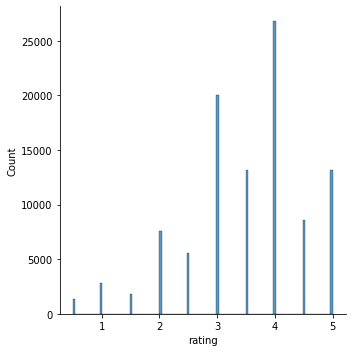

In [29]:
sns.displot(ratings_df['rating'])

In [30]:
# liked를 기준으로 영화 추천 
# 평점이 4 이상인 경우 1, 아니면 0으로 분류
ratings_df['liked'] = np.where(ratings_df['rating'] >= 4, 1, 0)
ratings_df['movieId'] = ratings_df['movieId'].astype(str)
train, test = train_test_split(ratings_df, random_state=100, test_size=0.2, stratify=ratings_df['userId'])
train

,userId,movieId,rating,timestamp,liked
78097,484,3911,4.0,1342294787,1
33900,232,10,3.0,1218167397,0
94410,599,26940,2.5,1519346264,0
85385,555,724,5.0,978745225,1
78341,487,31658,3.5,1428574498,0
...,...,...,...,...,...
79624,495,7163,4.5,1458636189,1
57080,380,1544,4.0,1493667555,1
56692,377,1262,4.5,1340341828,1
96597,603,2118,3.0,953925630,0


In [31]:
print("number of train data:", len(train))
print("number of test data: ", len(test))

number of train data: 80668
number of test data:  20168


In [32]:
# single user를 기준으로 4점 이상으로 평가한 영화와 4점 미만으로 평가한 영화를 나눠 각각 Item2Vec training 데이터로 사용
user_grouped = train.groupby(['liked', 'userId'])
user_movie_list = [user_grouped.get_group(gp)['movieId'].tolist() for gp in user_grouped.groups]
user_movie_list[0]

['3243',
 '1377',
 '1408',
 '2528',
 '223',
 '2338',
 '1030',
 '1396',
 '1644',
 '1219',
 '1445',
 '2617',
 '296',
 '316',
 '3247',
 '1676',
 '3176',
 '1580',
 '780',
 '648',
 '423',
 '736',
 '2253',
 '1258',
 '500',
 '2657',
 '2389']

In [33]:
len(user_movie_list)

1215

## gensim의 [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- gensim에서 다양한 ML 라이브러리들을 제공합니다
- 그 중에서 가장 많이 사용되는 Word2Vec 라이브러리로 CBOW와 SkipGram을 모두 지원합니다

In [34]:
from gensim.models.word2vec import Word2Vec

'''
user_movie_list(유저별 liked or not 한 영화)를 Word2Vec으로 학습 --> 영화별로 유사도 계산 가능
그룹별로 분리가 되었으므로 liked한 영화끼리는 유사도 점수가 높을 것
vector_size = 임베딩 벡터 사이즈
min_count = 효과적인 모델학습을 위한 영화별 최소 등장횟수
sg = SkipGram 사용시 1, CBOW 사용시 0
hs = negative sampling을 사용시 0
negative = 1개의 positive sample 당 negative sample의 개수
window = window_size --> 크게 잡는 이유는 문장 내 모든 item끼리 학습이 되어야 하므로
'''
model = Word2Vec(sentences=user_movie_list,
                 epochs=5, vector_size=100,
                 min_count=3, workers=4, sg=1, hs=0,
                 negative=5, window=9999999
                 )
word_vectors = model.wv

In [37]:
word_vectors['30793']

array([-0.0610266 , -0.1935339 ,  0.01464065,  0.14920636,  0.24811989,
       -0.02694466,  0.05792691, -0.01002752, -0.1358366 , -0.28848058,
       -0.11742902, -0.18456967, -0.06555612, -0.03655262, -0.038583  ,
       -0.24491788,  0.25112304,  0.06632326,  0.02520539,  0.0785951 ,
       -0.06551794,  0.04642465, -0.24851312, -0.02780095,  0.08946848,
        0.3249434 , -0.03176632,  0.03361163, -0.08565512,  0.2307677 ,
        0.33424026,  0.18903948,  0.05952373, -0.23424214,  0.06532127,
       -0.12123617, -0.20116085, -0.10843157, -0.1998411 , -0.11690626,
       -0.176419  ,  0.31277835,  0.01979651,  0.5005769 ,  0.020678  ,
       -0.06278321,  0.26816043,  0.02294869,  0.12766968,  0.08040022,
        0.00266246,  0.14265391, -0.17971845, -0.15335153, -0.25931373,
        0.2003774 ,  0.10240966, -0.2910146 , -0.09734452, -0.01058424,
       -0.11567602,  0.1572845 , -0.2896679 , -0.06281748,  0.02328274,
       -0.01987722, -0.3851129 , -0.11227423, -0.09552251, -0.12

## 주어진 아이템에 대한 연관 추천
- 주어진 아이템 벡터와 가장 비슷한 아이템 벡터를 찾는 테스크입니다.
- Item2Vec와 MF 모두 아이템 벡터를 생성하는 테스크라고 볼 수 있으며 지난 시간에 배운 annoy도 사용할 수 있습니다.

In [40]:
movies_df[movies_df['movieId'] == 30793]

,movieId,title,genres
5735,30793,Charlie and the Chocolate Factory (2005),Adventure|Children|Comedy|Fantasy|IMAX


In [41]:
# 주어진 아이템에 대해서 비슷한 아이템을 cosine 유사도로 구합니다

topn = 10
positive_list = ['30793']
similar_movies = model.wv.most_similar(positive=positive_list, topn=topn)
similar_movies

[('7147', 0.685655415058136),
 ('39183', 0.6834330558776855),
 ('4025', 0.6556235551834106),
 ('8373', 0.6527189016342163),
 ('53956', 0.6515734195709229),
 ('4744', 0.6495332717895508),
 ('5481', 0.6481220126152039),
 ('3943', 0.6441734433174133),
 ('6483', 0.6417502164840698),
 ('7173', 0.6412131190299988)]

In [44]:
similar_movie_list = [movie_id for movie_id, score in similar_movies]
movies_df['movieId'] = movies_df['movieId'].astype(str)
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
2940,3943,Bamboozled (2000),Comedy
3009,4025,Miss Congeniality (2000),Comedy|Crime
3477,4744,Jeepers Creepers (2001),Horror
3903,5481,Austin Powers in Goldmember (2002),Comedy
4405,6483,From Justin to Kelly (2003),Musical|Romance
4796,7147,Big Fish (2003),Drama|Fantasy|Romance
4814,7173,Along Came Polly (2004),Comedy|Romance
5171,8373,"Stepford Wives, The (2004)",Comedy|Fantasy|Thriller
6028,39183,Brokeback Mountain (2005),Drama|Romance
6517,53956,Death at a Funeral (2007),Comedy


In [46]:
# 2개 이상의 아이템과 가까운 영화 추출시 해당 아이템 벡터들의 element-wise 평균을 구하여 코사인 유사도 계산
# model.wv.most_similar() 모듈 내에서 자동으로 수행되는 듯!
topn=10
positive_list = ['50912', '56941']
similar_movie_list = [movie_id for movie_id, score in model.wv.most_similar(positive=positive_list, topn=topn)]
movies_df[movies_df['movieId'].isin(similar_movie_list)]

,movieId,title,genres
3159,4248,Josie and the Pussycats (2001),Comedy
6225,45732,My Super Ex-Girlfriend (2006),Comedy|Fantasy|Romance
6680,57951,Fool's Gold (2008),Action|Adventure|Comedy|Romance
6756,59725,Sex and the City (2008),Comedy|Romance
7188,72407,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller
7351,78316,Letters to Juliet (2010),Drama|Romance
7716,90376,We Need to Talk About Kevin (2011),Drama|Thriller
8227,103984,"Great Beauty, The (Grande Bellezza, La) (2013)",Comedy|Drama
8433,111659,Maleficent (2014),Action|Adventure|Children|IMAX
8994,139642,Southpaw (2015),Action|Drama


## 유저에게 아이템 추천

In [49]:
# 실제 user에게 추천시 user가 liked 했던 item을 positive_list로 사용
# 이때 모델 하이퍼파라미터인 min_count로 인해 모델 학습 안됐던 item은 제외
df = train[train['liked'] == 1]
df = df[df['movieId'].isin(model.wv.index_to_key)]
user_liked_train_movies = df.groupby('userId').agg({'movieId' : lambda x: x.tolist()})['movieId'].to_dict() # user별 좋아한 movie 리스트

In [52]:
df_2 = test[test['liked'] == 1]
user_liked_test_movies = df_2.groupby('userId').agg({'movieId' : lambda x: x.tolist()})['movieId'].to_dict()

In [54]:
top_n = 20
precisions = []
recalls = []
cold_start = 0

# total user에 대해 추천 진행
for user_id, liked_items in user_liked_test_movies.items():

  if user_id in user_liked_train_movies:
    # test 데이터에서 liked한 item
    relevant = liked_items
    
    # train에서 liked한 item 리스트로 Item2Vec 모델을 기반으로 추천 item 생성
    train_liked_items = user_liked_train_movies[user_id]
    recomm = [movie_id for movie_id, score in model.wv.most_similar(positive=train_liked_items, topn=top_n)]
  
  else:
    cold_start += 1
    continue
  
  intersect = set(relevant).intersection(set(recomm))
  precision = len(intersect) / len(recomm)
  recall = len(intersect) / len(relevant)

  precisions.append(precision)
  recalls.append(recall)

print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

precision@k: 0.06856187290969899
recall@k: 0.1513867060254425
cold_start_user: 0
